In [9]:
import numpy as np
import pandas as pd
import fancyimpute as imp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from scipy.stats import variation 
from sklearn import cross_validation
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

Downloaded the APS Failure data from: https://archive.ics.uci.edu/ml/datasets/APS+Failure+at+Scania+Trucks# . The dataset contains a training set and a test set. The training set contains 60,000 rows, of which 1,000 belong to the positive class and 171 columns, of which one is the class column. All attributes are numeric.

In [10]:
def clean_data(data):
    """ Cleans data to change the ? into np.nan values
    Parameters
    ----------
    data : pandas dataframe
    Results
    ---------
    returns cleaned dataframe
    """
    data.replace('na', np.nan, inplace = True)
    clean_data = data.apply(pd.to_numeric, errors = 'ignore')
    return clean_data

In [11]:
def binarize(data):
    """ Changes the class variable from being {neg, pos} to {0,1} for use in Random Forest 
    Parameters
    ----------
    data : pandas dataframe
    Results
    ---------
    returns dataframe
    """
    data.replace('neg', 0, inplace = True)
    data.replace('pos', 1, inplace = True)
    return data 

In [12]:
#Reads in training and testing datasets
df_train = pd.read_csv('aps_failure_training_set.csv')
df_test = pd.read_csv('aps_failure_test_set.csv')

#Concatenates train and test into one dataframe
df = pd.concat([df_train, df_test])

In [13]:
df = clean_data(df)
data_cols = df.columns.values.tolist()
target = ['class']
feature_cols = [i for i in data_cols if i not in target]
X_incomplete = df[feature_cols]

DATA PREPERATION

This data set has missing values. Since the number of data with missing values is significant, discarding them is not a good idea. I researched different types of data imputation methods and decided that I will use median imputation.

In [14]:
def data_imputation(X_incomplete,features, impute):
    """ Imputes the missing values specified by the option impute parameter 
        Parameters
        ----------
        X_incomplete : pandas dataframe, frame representing the predictors of incomplete data
        features: list, column names for creating the pandas dataframe
        impute : string, specifying the type of imputation to perform on the missing values,
        Results
        ---------
        returns pandas dataframe of the predictors that are filled
        """
    if impute == 'KNN':
        # Use 3 nearest rows which have a feature to fill in each row's missing features
        X_filled_knn = imp.KNN(k=3).complete(X_incomplete)
        return pd.DataFrame(X_filled_knn, columns = features)
    elif impute == 'MICE':
        # Multiple Imputation Technique
        X_filled_mice = imp.MICE().complete(X_incomplete)
        return pd.DataFrame(X_filled_mice, columns = features)   
    elif impute == 'MEAN':
        return X_incomplete.fillna(X_incomplete.mean())
    elif impute == 'MEDIAN':
        return X_incomplete.fillna(X_incomplete.median())

Based on the analysis in the reference paper below, they used the this dataset and imputed the missing values with the median of each feature therefore that is imputation method I used for this analysis.

Reference Paper:
Gondek C., Hafner D., Sampson O.R. (2016) Prediction of Failures in the Air Pressure System of Scania Trucks Using a Random Forest and Feature Engineering. Advances in Intelligent Data Analysis XV. IDA 2016. Lecture Notes in Computer Science, vol 9897. Springer, Cham 

In [15]:
X_filled = data_imputation(X_incomplete, feature_cols, 'MEDIAN')

For each of the 170 features, I calculated the coefficient of variation CV = s/m where s is sample variance and m is sample mean to see the distribution of the data. 

In [16]:
variation = X_filled.std()/X_filled.mean()
variation

aa_000      4.328608
ab_000      9.740521
ac_000      2.309299
ad_000    274.790378
ae_000     23.271357
af_000     19.007953
ag_000     92.507510
ag_001     42.566145
ag_002     17.827963
ag_003      8.854130
ag_004      5.538276
ag_005      2.994108
ag_006      2.364742
ag_007      2.838143
ag_008      6.343995
ag_009     32.535395
ah_000      2.327355
ai_000     18.701476
aj_000     43.598946
ak_000     84.875146
al_000      9.210860
am_0        9.163255
an_000      2.265608
ao_000      2.286911
ap_000      3.108118
aq_000      2.871101
ar_000     11.079624
as_000    115.082077
at_000     23.431463
au_000     86.992248
             ...    
dl_000     40.153018
dm_000     37.039731
dn_000      2.895279
do_000      2.243998
dp_000      2.074635
dq_000     22.205325
dr_000      6.906448
ds_000      2.342366
dt_000      2.214215
du_000      2.931806
dv_000      3.615395
dx_000      5.355316
dy_000      7.881550
dz_000     51.616121
ea_000     34.353213
eb_000      4.853240
ec_00       2

Each feature with its associated coefficient of variation is shown in the output of the block above.

In [17]:
def correlation_matrix(data, size = 20):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''
    
    correlations = data.corr()
    names = data.columns.values.tolist()
    # plot correlation matrix
    fig, ax = plt.subplots(figsize=(size, size))
    cax = ax.matshow(correlations, vmin=-1, vmax=1)
    fig.colorbar(cax)
    ticks = np.arange(0,len(names),1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_xticklabels(names)
    ax.set_yticklabels(names)
    plt.show()

Plotted a correlation matrix with pandas

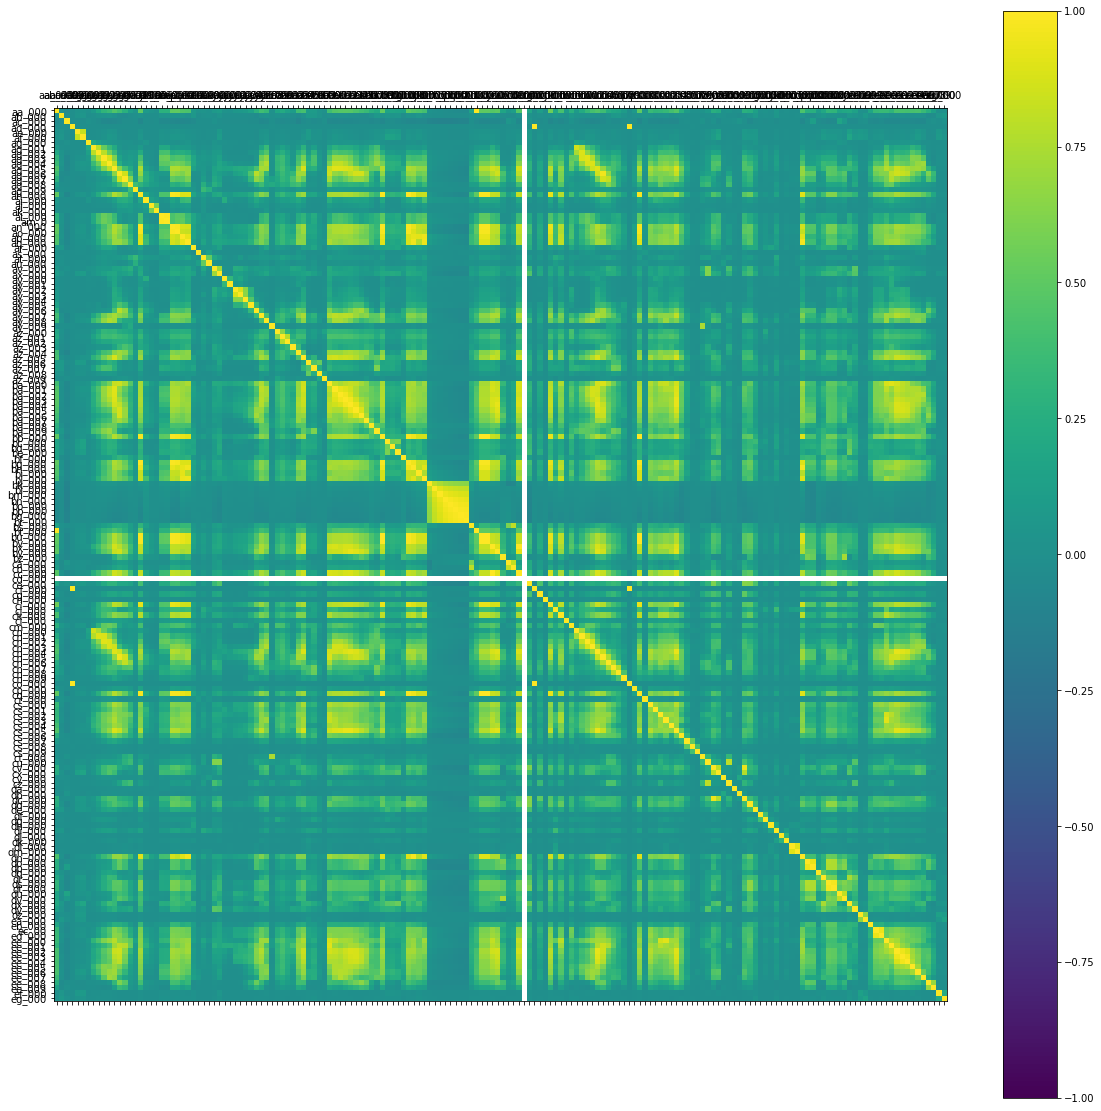

In [18]:
#Plots a Correlation Matrix
correlation_matrix(X_filled)

In [19]:
N = int(np.sqrt(170))
selected_features = variation.nlargest(n=N).index.tolist()
X_selected = X_filled[selected_features]

In [20]:
cols = X_selected.columns.values.tolist()
print(cols)

['cf_000', 'co_000', 'ad_000', 'cs_009', 'dj_000', 'dh_000', 'df_000', 'as_000', 'ag_000', 'au_000', 'ak_000', 'az_009', 'ay_009']


In [21]:
# This adds the class label to be the last column in the dataframe
df_new = pd.concat([X_selected, df['class']], axis = 1)

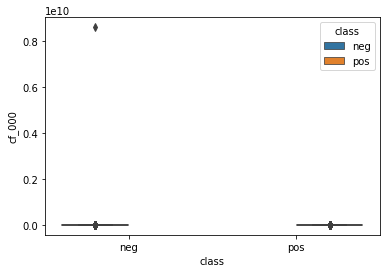

In [22]:
sns.boxplot(x = 'class', y = 'cf_000', hue = 'class', data=df_new)

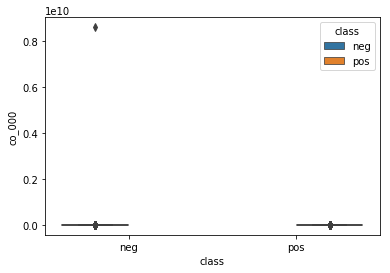

In [23]:
sns.boxplot(x = 'class', y = 'co_000', hue = 'class', data=df_new)

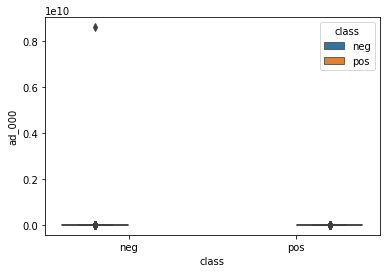

In [24]:
sns.boxplot(x = 'class', y = 'ad_000', hue = 'class', data=df_new)

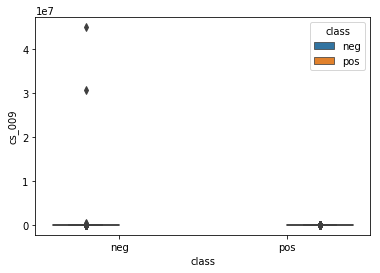

In [25]:
sns.boxplot(x = 'class', y = 'cs_009', hue = 'class', data=df_new)

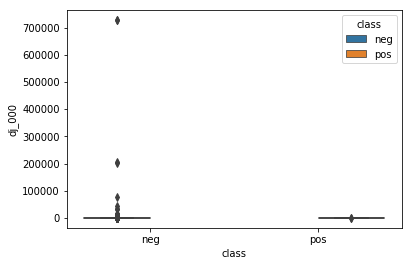

In [26]:
sns.boxplot(x = 'class', y = 'dj_000', hue = 'class', data=df_new)

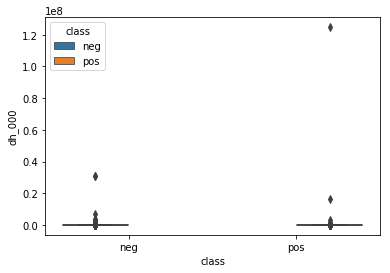

In [27]:
sns.boxplot(x = 'class', y = 'dh_000', hue = 'class', data=df_new)

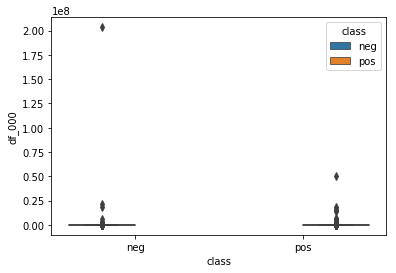

In [28]:
sns.boxplot(x = 'class', y = 'df_000', hue = 'class', data=df_new)

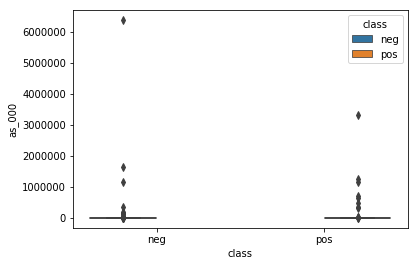

In [29]:
sns.boxplot(x = 'class', y = 'as_000', hue = 'class', data=df_new)

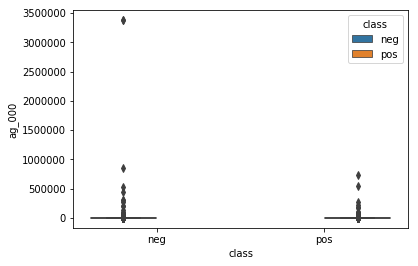

In [30]:
sns.boxplot(x = 'class', y = 'ag_000', hue = 'class', data=df_new)

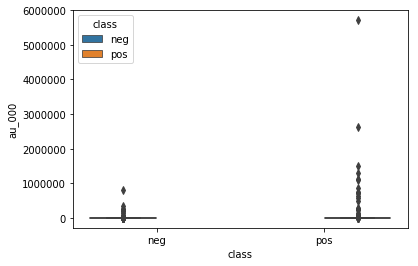

In [31]:
sns.boxplot(x = 'class', y = 'au_000', hue = 'class', data=df_new)

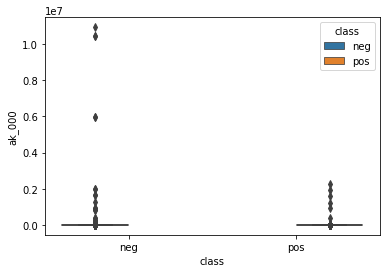

In [32]:
sns.boxplot(x = 'class', y = 'ak_000', hue = 'class', data=df_new)

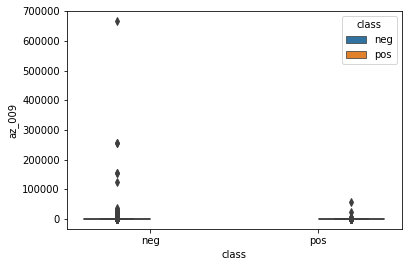

In [33]:
sns.boxplot(x = 'class', y = 'az_009', hue = 'class', data=df_new)

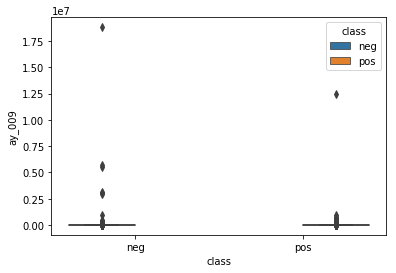

In [34]:
sns.boxplot(x = 'class', y = 'ay_009', hue = 'class', data=df_new)

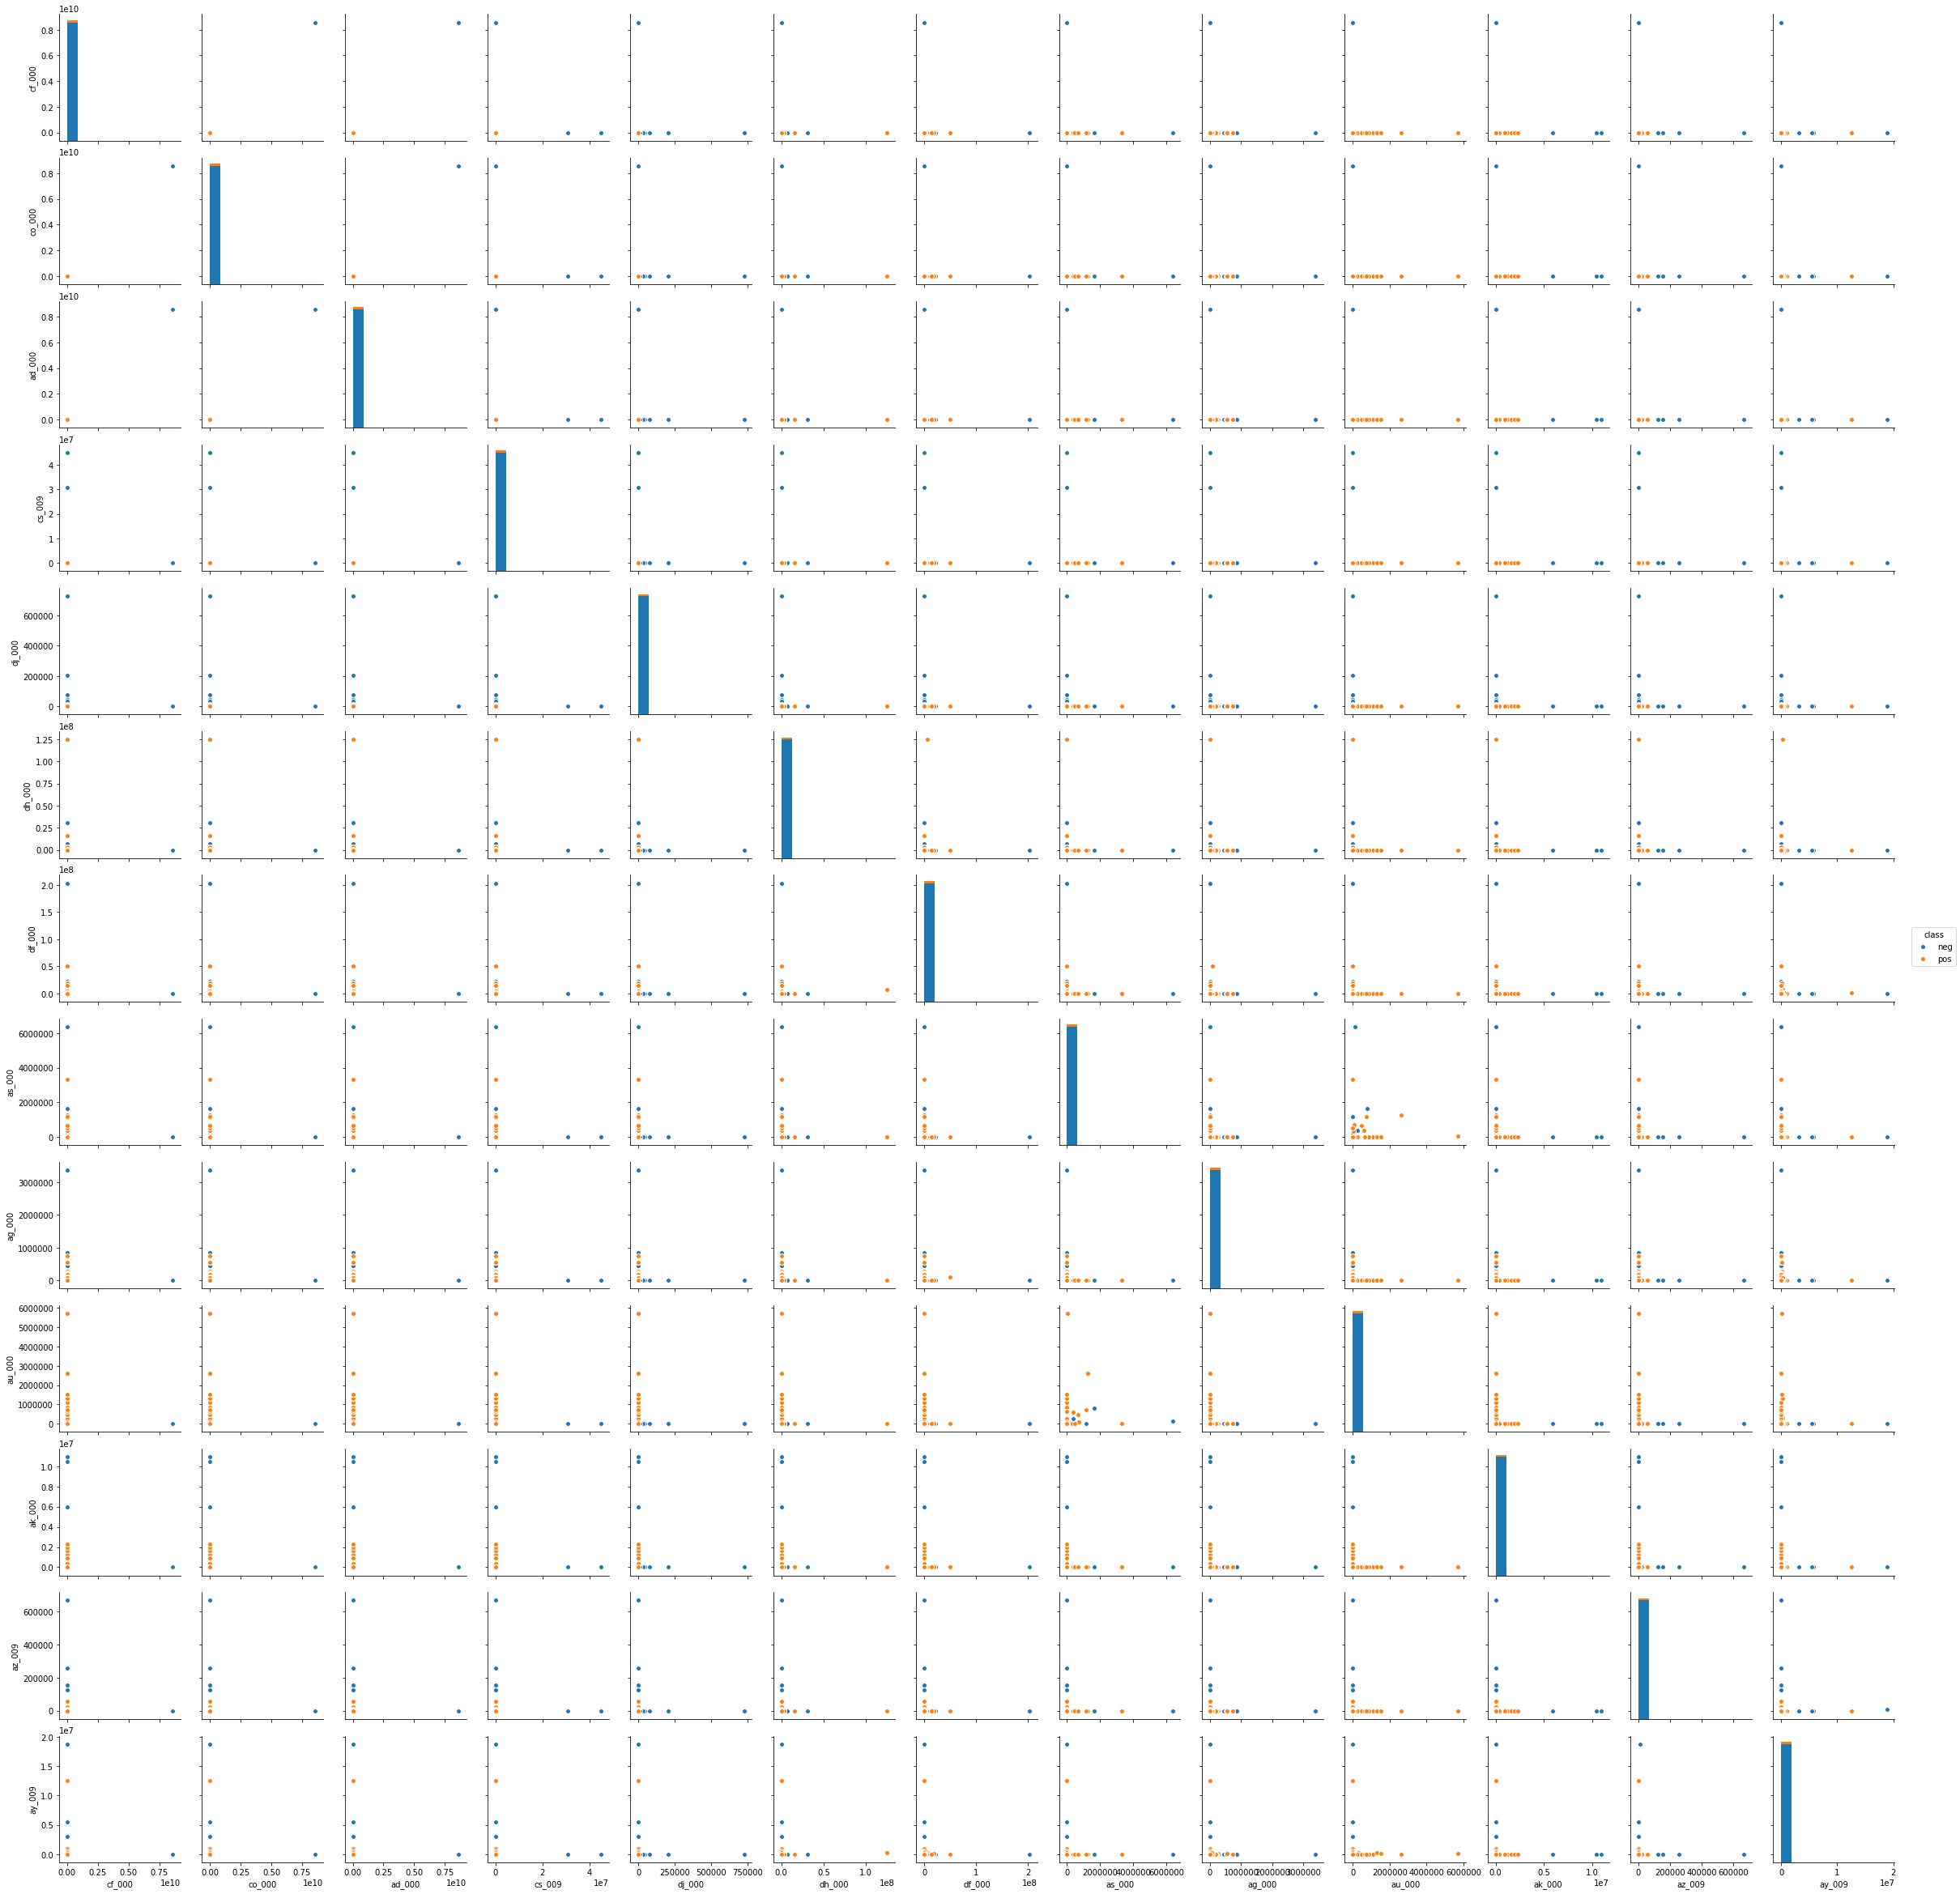

In [35]:
sns.pairplot(df_new, hue = 'class')
plt.show()

From the pair plots and boxplots shown above for the selected features, it is clear that there exists a large proportion of data with very low values for that specific feature in both the positive and negative classes. This is in agreement with the associated high coefficient of variation for all of these features. One clear observation is that there is a significant class imbalance towards the negative class, delineated by the bar plots on the diagonal of the pair plots figure. 

It is a good Idea to check to see if the dataset is imbalanced.

In [36]:
df['class'].value_counts()

neg    74625
pos     1375
Name: class, dtype: int64

As you can see from the number of observations that belong to the positive and negative class respectively, there is a large marginal class imbalance that is heavily skewed towards the negative class. Around 98.2% of the total data belongs to the positive class, while only 1.8% belongs to the positive class.

In the following section, I train random forest to classify the data set. I first train the model by not compensating for class imbalance in the data set. I report the confusion matrix, ROC, AUC, and misclassification for training and test sets. I also provide the Out of Bag error estimate and compare it to the test error.

In [37]:
def train_test_split(X,Y):
    """ Breaks data into training and testing sets 
        Parameters
        ----------
        X : pandas dataframe, frame representing the predictors
        Y : pandas series, series representing the target 
        select : list, default None means it takes all the predictors,
        but if there is a list just use those predictors in training
        Results
        ---------
        returns X_train, Y_train, X_test, Y_test
        """
    X_train = X[:60000]
    X_test = X[60000:]
    Y_train = Y[:60000]
    Y_test = Y[60000:]
    
    return X_train, Y_train, X_test, Y_test 

In [38]:
def show_ROC(Y, predict_probs,roc_auc, sample):
    fpr, tpr, thresholds = metrics.roc_curve(Y, predict_probs)
    plt.figure()
    plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(sample + ' Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

In [39]:
def calculate_metrics(model, X_train, Y_train, X_test, Y_test):
    
    results = {}
    #Predicting on the trained model, with training set and test set
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)

    #Confusion Matrix for Test and Training Sets
    print('Train Confusion Matrix')
    print(metrics.confusion_matrix(Y_train, train_pred))
    print('Test Confusion Matrix')
    print(metrics.confusion_matrix(Y_test, test_pred))

    #AUC score for Test and Training Sets
    print ('Trainig (AUC = %0.2f)' % (metrics.roc_auc_score(Y_train, train_pred)))
    print ('Testing (AUC = %0.2f)' % (metrics.roc_auc_score(Y_test, test_pred)))
    
    oob_estimate = (1 - model.oob_score_)*100
    rf_err = (1 - metrics.accuracy_score(Y_test, test_pred))*100
    #OOB Estimate of model 
    print('OOB Error Estimate: %.4f%%' % oob_estimate) #This is for the training sample
    print('Test Error: %.4f%%' % rf_err) #This is for the training sample
    
    show_ROC(Y_train, model.predict_proba(X_train)[:,1],metrics.roc_auc_score(Y_train, train_pred),'Train')
    show_ROC(Y_test, model.predict_proba(X_test)[:,1],metrics.roc_auc_score(Y_test, test_pred),'Test')


In [40]:
# Dataframe of imbalanced data that has class as either {0,1}
df_imbalanced = pd.concat([X_filled, df['class']], axis = 1)
df_imbalanced = binarize(df_imbalanced)

In [41]:
#Splitting up the dataset into corresponding test and train
X_train, Y_train, X_test, Y_test = train_test_split(df_imbalanced.drop(['class'], axis=1),df_imbalanced['class'])

In [ ]:
#Fitting Random Forest for the imbalanced dataset
clf = RandomForestClassifier(oob_score = True)
clf.fit(X_train, Y_train)

Train Confusion Matrix
[[58999     1]
 [   44   956]]
Test Confusion Matrix
[[15606    19]
 [  121   254]]
Trainig (AUC = 0.98)
Testing (AUC = 0.84)
OOB Error Estimate: 0.8767%
Test Error: 0.8750%


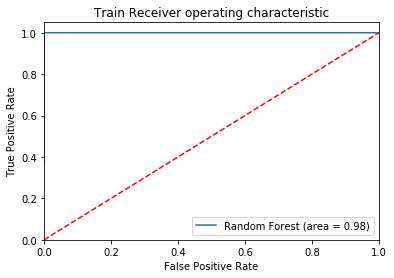

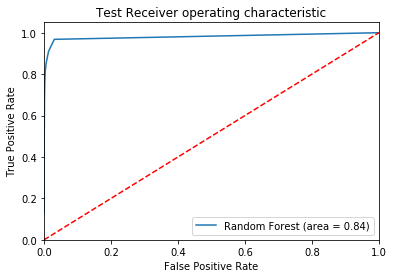

In [43]:
calculate_metrics(clf, X_train, Y_train, X_test, Y_test)

The results above show the ROC plots, AUC score, confusion matrix and test misclassification error for the Random forest model. We can conclude that the OOB estimate obtain from the model is very accurate in predicting the test error. One aspect of the results that is important to note from the test confusion matrix, however, is that the model incorrectly classified 32% of the positive observations, which is not ideal. Since random forests uses bootstrap sampling with replacement from the training data, the lack of positive class observations may cause the  In the next section, I will address this issue.

I researched how class imbalance is addressed in random forests and I found that there is a parameter in sklearns Random Forest Classifier that assigns custom class weights to specified classes, which can help the classifier when there is a large imbalance in the dataset. Therefore, I specified some weights to use with cross validation and changed the scoring to f1_weighted, becuase we are more interested in the performance of the positive calss identification because there are so little observations corresponding to that class.

In [44]:
params = {
    'class_weight':[{0: 1, 1: w} for w in [1, 5, 10, 15, 20, 25]]
}

In [ ]:
clf_rf = RandomForestClassifier(oob_score = True)
grid = GridSearchCV(estimator = clf_rf, param_grid = params, cv = 5, scoring = 'f1_weighted', refit = True)
grid.fit(X_train, Y_train)


In [46]:
print(grid.best_params_)

{'class_weight': {0: 1, 1: 1}}


However, from this test of trying out different class weights, the different weighting for the minority class did not seem to alter the performance of the classifier since the best param weighting was the same as I used before. Therefore, I tried a different approach which is an oversampling technique of the majority class using SMOTE.

In [47]:
sm = SMOTE(random_state=12, ratio = 'minority')
x_train_res, y_train_res = sm.fit_sample(X_train, Y_train)

In [ ]:
clf_rf = RandomForestClassifier(oob_score = True)
clf_rf.fit(x_train_res, y_train_res)

Train Confusion Matrix
[[58990    10]
 [    4   996]]
Test Confusion Matrix
[[15545    80]
 [   84   291]]
Trainig (AUC = 1.00)
Testing (AUC = 0.89)
OOB Error Estimate: 1.1466%
Test Error: 1.0250%


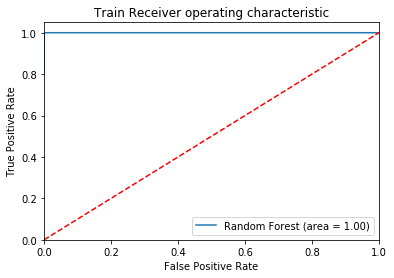

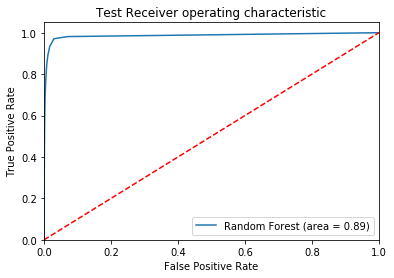

In [49]:
calculate_metrics(clf_rf, X_train, Y_train, X_test, Y_test)

By performing oversampling using SMOTE, we have reduced the positive class misclassification error down to 18.9%, which is better than the misclassification error seen before without oversampling. In addition, the overall test performance improved as well thereby leading me to conclude that oversampling is a good method to deal with imbalanced classes for this dataset. 